# Ambar Roy
CNN model used on Cifar-100

# Import statements

In [226]:
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical

from sklearn.preprocessing import OneHotEncoder
from keras.layers import Input,Activation,Add,AveragePooling2D,Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,UpSampling2D,Lambda,ZeroPadding2D

from keras.models import Model
from keras.datasets import cifar100
from keras.preprocessing import image

from keras.applications import ResNet50

# Loading training data and test data

In [201]:
(x_train, y_train), (x_test, y_test)=cifar100.load_data(label_mode='coarse')
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


(10000, 32, 32, 3)
(50000, 100)


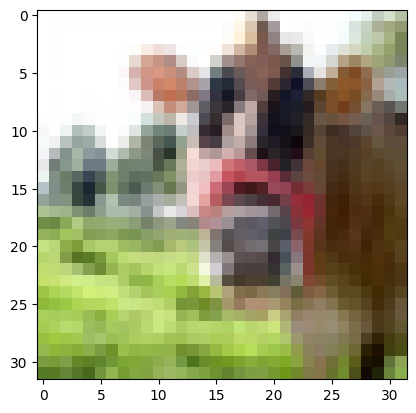

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [202]:
x_train = x_train*1.0/255
x_test = x_test*1.0/255


# x_train=np.array([cv2.resize(img, (140, 140)) for img in x_train])
# x_test= np.array([cv2.resize(img, (140, 140)) for img in x_test])

# ohc=OneHotEncoder()
# y_train = ohc.fit_transform(y_train.reshape(-1, 1)).toarray().astype(int)
# y_test = ohc.transform(y_test.reshape(-1, 1)).toarray().astype(int)
y_train=to_categorical(y_train, num_classes=100)
y_test=to_categorical(y_train, num_classes=100)

print(x_test.shape)
print(y_train.shape)
plt.imshow(x_train[0])
plt.show()
print(y_train[0])

# Data Augmentation

In [203]:
train_datagen = image.ImageDataGenerator( 
    rotation_range = 10,  
    zoom_range = 0.1, 
    width_shift_range = 0.1,  
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,  
    vertical_flip = False
    )
train_datagen.fit(x_train)

# Adjust Learning Rate if validation accuracy is not improving
May occur if Exploding gradient is reached

In [221]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

# Configuring ResNet50

In [222]:
def identity_block(X, f, filters):
    X_shortcut=X

    X=tf.Conv2D(filters=filters[0],kernel_size=1,strides=(1,1), padding='valid')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)
    X=tf.Activation('relu')(X)

    X=tf.Conv2D(filters=filters[1],kernel_size=f,strides=(1,1), padding='same')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)
    X=tf.Activation('relu')(X)

    X=tf.Conv2D(filters=filters[2],kernel_size=1,strides=(1,1), padding='valid')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)

    X=tf.Add()([X_shortcut,X])
    X=tf.Activation('relu')(X)

    return X

In [223]:
def convolutional_block(X, f, filters, s=2):
    X_shortcut=X

    X=tf.Conv2D(filters=filters[0],kernel_size=1,strides=(s,s), padding='valid')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)
    X=tf.Activation('relu')(X)

    X=tf.Conv2D(filters=filters[1],kernel_size=f,strides=(1,1), padding='same')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)
    X=tf.Activation('relu')(X)

    X=tf.Conv2D(filters=filters[2],kernel_size=1,strides=(1,1), padding='valid')(X)
    X=tf.BatchNormalization(axis=3)(X, training=True)

    X_shortcut=tf.Conv2D(filters=filters[2],kernel_size=1,strides=(s,s), padding='valid')(X_shortcut)
    X_shortcut=tf.BatchNormalization(axis=3)(X_shortcut, training=True)

    X=tf.Add()([X_shortcut,X])
    X=tf.Activation('relu')(X)

    return X

In [224]:
def build_resnet(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    #layer = data_augmenter()(input_img)

    layer =tf.ZeroPadding2D((3, 3))(input_img)

    layer=tf.Conv2D(filters=64,kernel_size=7,strides=(2,2))(layer)
    layer=tf.BatchNormalization(axis=3)(layer, training=True)
    layer=tf.Activation('relu')(layer)
    layer=tf.MaxPooling2D((3, 3), strides=(2, 2))(layer)

    layer=convolutional_block(layer,3,[64,64,256],1)
    layer=identity_block(layer,3,[64,64,256])
    layer=identity_block(layer,3,[64,64,256])

    layer=convolutional_block(layer,3,[128,128,512],2)
    layer=identity_block(layer,3,[128,128,512])
    layer=identity_block(layer,3,[128,128,512])
    layer=identity_block(layer,3,[128,128,512])

    layer=convolutional_block(layer,3, [256, 256, 1024],2)
    layer=identity_block(layer,3, [256, 256, 1024])
    layer=identity_block(layer,3, [256, 256, 1024])
    layer=identity_block(layer,3, [256, 256, 1024])
    layer=identity_block(layer,3, [256, 256, 1024])
    layer=identity_block(layer,3, [256, 256, 1024])

    layer=convolutional_block(layer,3, [512, 512, 2048],2)
    layer=identity_block(layer,3, [512, 512, 2048])
    layer=identity_block(layer,3, [512, 512, 2048])

    layer=tf.AveragePooling2D(pool_size=(2, 2),padding='same')(layer)
    layer=tf.Flatten()(layer)

    outputs=tf.Dense(units= 20 , activation='softmax')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [225]:
myresnet18 = build_resnet(input_shape=(32, 32, 3))

AttributeError: module 'tensorflow' has no attribute 'ZeroPadding2D'

# Creating Model

In [208]:
# Author Ambar Roy

cnn=keras.models.Sequential(name='ResNet50-for-Cifar100')

cnn.add(myresnet36)
cnn.add(Dropout(.25,name='Drop1'))
cnn.add(Flatten(name='Flatten'))
cnn.add(Dense(1024, activation='relu',name='Dense1'))
cnn.add(Dropout(.25,name='Drop2'))
cnn.add(Dense(256, activation='relu',name='Dense2'))
cnn.add(BatchNormalization(name='BN'))
cnn.add(Dense(100, name='OL', activation='softmax'))
cnn.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2,momentum=0.9),loss='categorical_crossentropy',metrics='accuracy')
cnn.build(input_shape=(None, 224, 224, 3))
cnn.summary()

NameError: name 'myresnet36' is not defined

# Training Model

In [ ]:
# cnn.load_weights('weights/cnn-model5.h5')
history=cnn.fit(x_train, y_train, verbose=1, batch_size=256, epochs=20, validation_split=0.2, callbacks = [learning_rate_reduction], shuffle=True)
pd.DataFrame(history.history)['accuracy'].plot(figsize=(8,5))
pd.DataFrame(history.history)['val_accuracy'].plot(figsize=(8,5))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

Epoch 1/20
157/157 [==============================] - 56s 341ms/step - loss: 2.5057 - accuracy: 0.3887 - val_loss: 3.5455 - val_accuracy: 0.1718 - lr: 0.0100
Epoch 2/20
157/157 [==============================] - 60s 384ms/step - loss: 1.8558 - accuracy: 0.4519 - val_loss: 2.8608 - val_accuracy: 0.2857 - lr: 0.0100
Epoch 3/20
157/157 [==============================] - 71s 452ms/step - loss: 1.7067 - accuracy: 0.4765 - val_loss: 2.4536 - val_accuracy: 0.3189 - lr: 0.0100
Epoch 4/20
157/157 [==============================] - 67s 425ms/step - loss: 1.6024 - accuracy: 0.5015 - val_loss: 2.2653 - val_accuracy: 0.3390 - lr: 0.0100
Epoch 5/20
157/157 [==============================] - 71s 451ms/step - loss: 1.5388 - accuracy: 0.5189 - val_loss: 2.2459 - val_accuracy: 0.3555 - lr: 0.0100
Epoch 6/20
157/157 [==============================] - 69s 437ms/step - loss: 1.4712 - accuracy: 0.5361 - val_loss: 2.6993 - val_accuracy: 0.3312 - lr: 0.0100
Epoch 7/20
157/157 [==============================] 

KeyboardInterrupt: 

# Testing Model

In [ ]:
# cnn.evaluate(x_test,y_test)